# Appliances with duty cycles


Some appliances may operate based on fixed duty cycle. For instance, you may think of a
dishwasher that follows a pre-determined program. This can be modelled by means of the 
`fixed_cycle` parameter, which allows to define a duty cycle consisting of up to two temporal
operation segments with distinct power consumption levels. 

Furthermore, we acknowledge that some of the appliances that can operate based on duty cucles
may still follow multiple, different duty cycles throughout a day or across seasons. An example
of an appliance characterised by variable duty cycles is a fridge. Fridges tend to follow 
different duty cycles throughout the day, depending on the ambient temperature (which also varies
across seasons) and/or frequency of user interaction (e.g., how often the door gets opened).
Accordingly, RAMP allows modelling up to 3 different duty cycles per appliance, giving room for
modulating the appliance's behaviour depending on any given factor of interest.

In this example, we model a fridge with 3 different duty cycles. The
time windows are defined for 3 different cycles across 3 different season
types:


| season type |               Standard cycle              |  Intermediate cycle |   Intensive cycle   |
|-------------|:-----------------------------------------:|:-------------------:|:-------------------:|
| Hot         | 00:00:00 - 04:59:00 & 20:01:00 - 23:59:00 | 05:00:00 - 07:59:00 | 08:00:00 - 20:00:00 |
| Warm        | 00:00:00 - 04:59:00 & 18:01:00 - 23:59:00 | 05:00:00 - 09:39:00 | 09:40:00 - 18:00:00 |
| Cold        | 00:00:00 - 04:59:00 & 20:01:00 - 23:59:00 | 05:00:00 - 20:00:00 |          -          |

### Creating the user and appliance

In [1]:
# importing functions
from ramp import User, UseCase, get_day_type
import pandas as pd

In [2]:
# creating user
household = User()

In [3]:
# creating the appliance
fridge = household.Appliance(
    name="Fridge",
    number=1,
    power=200,
    num_windows=1,
    func_time=1400,
    time_fraction_random_variability=0,
    func_cycle=30,
    fixed="yes",
    fixed_cycle=3,  # number of cycles
)

/home/fl/anaconda3/envs/ramp/lib/python3.8/site-packages/rampdemand-0.5.0-py3.8.egg/ramp/core/core.py:850: DeprecationWarning: This function is deprecated and not supported since version v0.4.0. Instead use the add_appliance method.
  warnings.warn("This function is deprecated and not supported since version v0.4.0. Instead use the add_appliance method.", DeprecationWarning)


In [4]:
# setting the functioning windows
fridge.windows([0, 1440])  # always on during the whole day, for all days of the year

### Characterising the specific cycles

As anticipated above, each cycle is characterised by two operation segments at different power levels. They can be defined as per the code below. In addition, it is possile to apply a random variability to the exact duration of the two segments (see the API documentation).

In [5]:
# assiging the specific cycles
# first cycle: intensive cycle
fridge.specific_cycle_1(
    p_11=200, # power level for the first operation segment
    t_11=10,  # duration of the first operation segment
    p_12=5,   # power level for the second operation segment
    t_12=20,  # duration of the second operation segment
)

# second cycle: intermediate cycle
fridge.specific_cycle_2(
    p_21=200,
    t_21=15,
    p_22=5,
    t_22=15,
)

# third cycle: standard cycle
fridge.specific_cycle_3(
    p_31=200,
    t_31=20,
    p_32=5,
    t_32=10,
)

After defining the cycle power and duration parameters, the time windows within a day at which the cycles occur should be specified by means of the 'cycle window' (`cw`). In fact, up to two time windows within a day can be specified for each of the 3 cycles. For instance, for `specific_cycle_3`, you may define an occurrence in the early morning (`cw31` in the code below) as well as one in the late evening (`cw32`).The windows defined across all cycles should not overlap.

In [6]:
# defining cycle behaviour
fridge.cycle_behaviour(
     cw11=[0, 229], cw12=[1201, 1440], cw21=[300, 479], cw31=[480, 1200]
)

### Building the profiles

In [7]:
use_case = UseCase(users=[household])
peak_time_range = use_case.calc_peak_time_range()

In [8]:
# days to build the profiles
days = [
    "2020-05-16", # a day in the 'Cold' season, based on RAMP's validation case study in Bolivia
    "2020-08-16", # a day in the 'Warm' season
    "2020-12-16", # a day in the 'Hot' season 
]

profiles = pd.DataFrame(index=range(0, 1440), columns=days)

for day_idx, day in enumerate(days):
    profile = household.generate_single_load_profile(
        prof_i=day_idx,  # the day to generate the profile
        peak_time_range=peak_time_range,
        day_type=get_day_type(day),
    )

    profiles[day] = profile

In [9]:
print(profiles)

      2020-05-16  2020-08-16  2020-12-16
0          0.001       0.001       0.001
1          0.001       0.001       0.001
2          0.001       0.001       0.001
3          0.001       0.001       0.001
4          0.001     200.000     200.000
...          ...         ...         ...
1435     200.000       5.000       0.001
1436     200.000       5.000       0.001
1437     200.000       5.000       0.001
1438       0.001       5.000       0.001
1439       0.001       0.001       0.001

[1440 rows x 3 columns]


<Axes: >

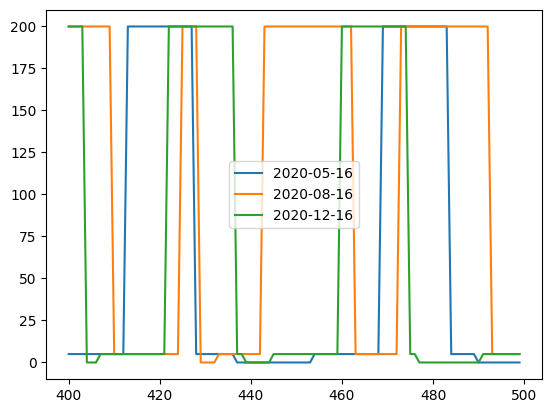

In [10]:
# plotting a part of the days
profiles.iloc[400:500].plot()